# Quickstart
The following notebook introduces `iconspy`'s datatypes and some of their associated methods.

Having followed through this tutorial you will be able to construct and visusalise `iconspy` sections.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import iconspy as ispy
import cmocean.cm as cmo

----Start loading pyicon.
Loading default parameters from /home/m/m301014/.conda/envs/ispy_py311/lib/python3.11/site-packages/pyicon/params_default.json.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


## Load and prepare the example data

We will load from netcdf files as `tgrid` which describes the model grid, and an `fxgrid` which contains bathymetry information.

We then have to put them in a format that `iconspy` can understand. For the `tgrid` this means calling `ispy.convert_tgrid_data`, and for the the `fxgrid` we must make sure the dimensions have the correct names.

In [2]:
shared_data_path = Path("/pool/data/ICON/oes/input/r0006/")
R02B04_path = shared_data_path / "icon_grid_0036_R02B04_O"
grid_path = R02B04_path / "R2B4_ocean-grid.nc"
fx_path = R02B04_path / "R2B4L40_fx.nc"

ds_tgrid = xr.open_dataset(grid_path)  # horizontal grid information
ds_fx = xr.open_dataset(fx_path)  # Contains bathymetry etc.

# Put datasets into the iconspy format
ds_IsD = ispy.convert_tgrid_data(ds_tgrid)

ds_fx = ds_fx.rename(
    {
        "ncells": "cell",
        "ncells_2": "edge",
        "ncells_3": "vertex",
    }
)



## Define the stations we want to connect
To define a section we need two or more points to connect. Typically we have a rough idea of where we want these points to be, and we would like to choose the model grid points closest to these coordinates. Sometimes we have a desire for one of the points to be on land.

In the below we will define a section near Fram Strait, stretching from a point on Greenland to a point offshore.

In [3]:
def setup_plot_area(ds_IsD):
    Slat, Nlat = -20, 20
    Wlon, Elon = -60, 0

    edges_in_region = ds_IsD["edge"].where(
        (ds_IsD["elon"] > Wlon) * (ds_IsD["elon"] < Elon) * (ds_IsD["elat"] > Slat) * (ds_IsD["elat"] < Nlat)
        , drop=True).astype("int32")


    lons = ds_IsD["vlon"].sel(vertex=ds_IsD["edge_vertices"])
    lats = ds_IsD["vlat"].sel(vertex=ds_IsD["edge_vertices"])

    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

    for edge in edges_in_region:
        ax.plot(
            lons.isel(edge=edge),
            lats.isel(edge=edge),
            color="black",
            alpha=0.2,
        )

    ax.scatter(
        ds_IsD["vlon"],
        ds_IsD["vlat"],
        s=4,
        transform=ccrs.PlateCarree(),
        color="tab:green"
    )

    ax.set_xlim(Wlon, Elon)
    ax.set_ylim(Slat, Nlat)
    ax.set_aspect("equal")

    ax.coastlines()
    ax.grid(False)
    return fig, ax

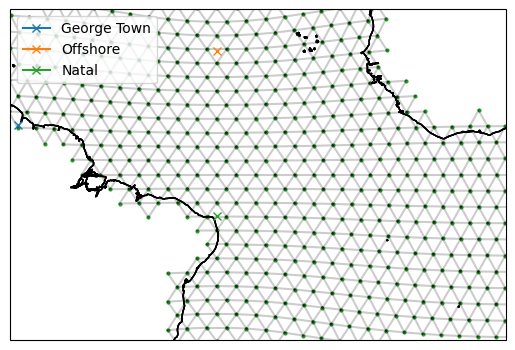

In [4]:
# Put in the approximate coordinates of the points we want
# Specify that we want the George Town point to be on the boundary
target_GeorgeTown = ispy.TargetStation("George Town", -59, 6, boundary=True)
target_offshore = ispy.TargetStation("Offshore", -35, 15, boundary=False)
target_Natal = ispy.TargetStation("Natal", -35, -5, boundary=True)

# Visualise the points
fig, ax = setup_plot_area(ds_IsD)
target_GeorgeTown.plot(ax=ax, gridlines=False)
target_offshore.plot(ax=ax, gridlines=False)
target_Natal.plot(ax=ax, gridlines=False)
gl = ax.gridlines()
gl.xlines, gl.ylines = False, False
ax.grid(visible=False)
ax.legend(loc=2)

The map shows the approximate location of the points we want to join. We can now find the model grid points nearest to them and plot them.

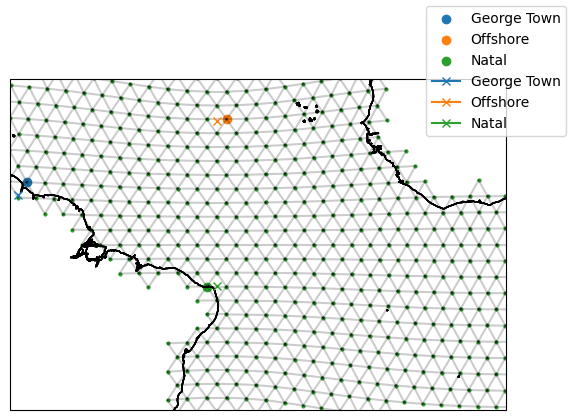

In [5]:
# Convert the target stations to model stations
model_GeorgeTown = target_GeorgeTown.to_model_station(ds_IsD)
model_offshore = target_offshore.to_model_station(ds_IsD)
model_Natal = target_Natal.to_model_station(ds_IsD)

fig, ax = setup_plot_area(ds_IsD)

# Plot the model stations (circles)
model_GeorgeTown.plot(ax=ax, gridlines=False)
model_offshore.plot(ax=ax, gridlines=False)
model_Natal.plot(ax=ax, gridlines=False)

# Compare with the target station (crosses)
target_GeorgeTown.plot(ax=ax, gridlines=False)
target_offshore.plot(ax=ax, gridlines=False)
target_Natal.plot(ax=ax, gridlines=False)

fig.legend()

## Connect stations to form sections

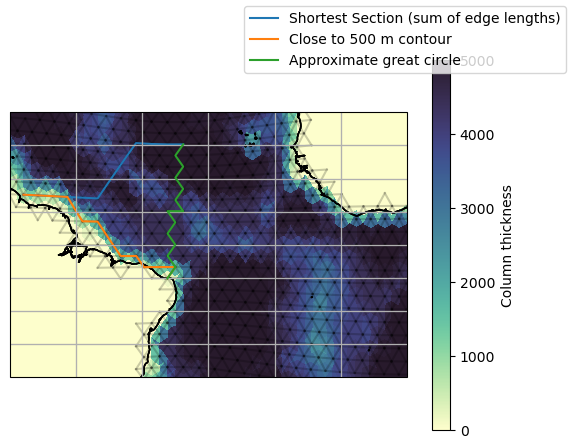

In [6]:
shortest = ispy.Section(
    "Shortest Section (sum of edge lengths)",
    model_GeorgeTown,
    model_offshore,
    ds_IsD,
    section_type="shortest"
)

great_circle = ispy.Section(
    "Approximate great circle",
    model_offshore,
    model_Natal,
    ds_IsD,
    section_type="great circle"
)

contour = ispy.Section(
    "Close to 500 m contour",
    model_Natal,
    model_GeorgeTown,
    ds_IsD,
    section_type="contour",
    contour_data=ds_fx["column_thick_e"],
    contour_target=500,
)

fig, ax = setup_plot_area(ds_IsD)
shortest.plot(ax=ax)
contour.plot(ax=ax)
great_circle.plot(ax=ax)

fig.legend()

cax = ax.tripcolor(
    ds_IsD["clon"],
    ds_IsD["clat"],
    ds_fx["column_thick_c"],
    vmin=0,
    vmax=5000,
    cmap=cmo.deep,
)

fig.colorbar(cax, ax=ax, label="Column thickness")

We can get the orientation of edges along a path by running the below:

In [16]:
great_circle.set_pyic_orientation_along_path(ds_IsD)
great_circle.edge_orientation

<xarray.DataArray 'edge' (step_in_path: 13)> Size: 104B
array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.])
Coordinates:
    elon          (step_in_path) float64 104B -34.4 -34.4 ... -35.59 -35.59
    elat          (step_in_path) float64 104B 14.33 12.65 ... -2.533 -4.222
    edge          (step_in_path) int32 52B 10010 9802 9798 ... 10547 10543 10531
  * step_in_path  (step_in_path) int32 52B 3531 3529 3521 ... 3795 3790 3789

## Connect sections to form a region

In [7]:
example_region = ispy.Region("Offshore of the Amazon", [shortest, great_circle, contour], ds_IsD)

/work/mh0256/m301014/iconspy/iconspy/utils.py:122: UserWarning: rename 'step_in_path_v' to 'step_in_path' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  edge_path_xr = edge_path_xr.rename(step_in_path_v="step_in_path")
/work/mh0256/m301014/iconspy/iconspy/utils.py:33: UserWarning: rename 'step_in_path_v' to 'step_in_path' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  vertex_path = vertex_path.rename(step_in_path_v="step_in_path")


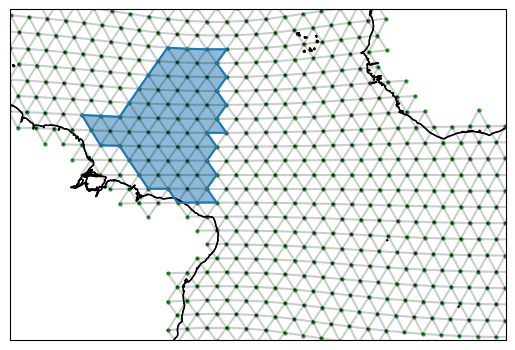

In [8]:
fig, ax = setup_plot_area(ds_IsD)
example_region.plot(ax=ax, gridlines=False)

Regions have paths of edges and also edge orientations that we can use for calcualting fluxes into the region

In [9]:
print(example_region.edge_circuit)
print(example_region.path_orientation)

<xarray.DataArray 'edge' (step_in_path: 32)> Size: 128B
array([ 7752, 10079, 10113, 10097, 10108,  9853, 10062, 10049, 10065, 10006,
       10010,  9802,  9798,  9782,  9789,  9872,  9866,  9864,  9878,  9882,
       10547, 10543, 10535, 10760, 10756, 10763, 10748, 10086, 10085, 10121,
       10125,  7793], dtype=int32)
Coordinates:
    elon          (step_in_path) float64 256B -50.17 -47.89 ... -49.62 -50.74
    elat          (step_in_path) float64 256B 7.166 7.053 7.848 ... 4.455 6.295
    edge          (step_in_path) int32 128B 7752 10079 10113 ... 10125 7793
    step_in_path  (step_in_path) int64 256B 1 2 3 4 5 6 7 ... 27 28 29 30 31 32
<xarray.DataArray (step_in_path: 32)> Size: 256B
array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1., -1.])
Coordinates:
    elon          (step_in_path) float64 256B -50.17 -47.89 ... -49.62 -50.74
    elat          (step_in_pa

Regions also have a list of the cells contained by them

In [10]:
example_region.contained_cells

<xarray.DataArray 'cell' (cell: 94)> Size: 376B
array([4941, 6248, 6250, 6251, 6256, 6258, 6259, 6260, 6261, 6262, 6263, 6280,
       6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6291, 6292, 6293,
       6294, 6295, 6297, 6299, 6300, 6301, 6302, 6303, 6305, 6390, 6426, 6435,
       6436, 6437, 6438, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448,
       6449, 6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6459, 6460, 6461,
       6462, 6463, 6465, 6471, 6476, 6477, 6478, 6486, 6487, 6488, 6489, 6490,
       6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6731,
       6868, 6869, 6870, 6872, 6874, 6875, 6876, 6877, 6878, 6879], dtype=int32)
Coordinates:
    clon     (cell) float64 752B -50.2 -35.0 -36.19 ... -38.55 -36.18 -37.37
    clat     (cell) float64 752B 6.618 8.872 9.691 ... -0.4345 -0.4301 -2.123
  * cell     (cell) int32 376B 4941 6248 6250 6251 6256 ... 6876 6877 6878 6879

We can also create a dataset representation of the region to be saved to a netcdf file for subsequent use.

In [11]:
example_region.to_ispy_section("test.nc", dryrun=True)  # set dryrun=False to actually save the file.

Output will be saved to test.nc
Not saving as dryrun=True


<xarray.Dataset> Size: 4kB
Dimensions:           (step_in_path: 32, step_in_path_v: 33, cell: 94)
Coordinates:
    elon              (step_in_path) float64 256B -50.17 -47.89 ... -50.74
    elat              (step_in_path) float64 256B 7.166 7.053 ... 4.455 6.295
    edge              (step_in_path) int32 128B 7752 10079 10113 ... 10125 7793
  * step_in_path      (step_in_path) int64 256B 1 2 3 4 5 6 ... 28 29 30 31 32
    vlon              (step_in_path_v) float64 264B -51.3 -49.04 ... -51.3
    vlat              (step_in_path_v) float64 264B 7.224 7.106 ... 5.365 7.224
    vertex            (step_in_path_v) int32 132B 2835 2837 3618 ... 2848 2835
    clon              (cell) float64 752B -50.2 -35.0 -36.19 ... -36.18 -37.37
    clat              (cell) float64 752B 6.618 8.872 9.691 ... -0.4301 -2.123
  * cell              (cell) int32 376B 4941 6248 6250 6251 ... 6877 6878 6879
Dimensions without coordinates: step_in_path_v
Data variables:
    edge_path         (step_in_path) int32 128B 7752 10079 10113 ... 10125 7793
    vertex_path       (step_in_path_v) int32 132B 2835 2837 3618 ... 2848 2835
    path_orientation  (step_in_path) float64 256B -1.0 1.0 -1.0 ... 1.0 -1.0
    contained_cells   (cell) int32 376B 4941 6248 6250 6251 ... 6877 6878 6879
Attributes:
    date:     2025-06-18 11:41:47

## Reconstruct sections from a region
Having produced a region we can also extract the sections that make it up. This can be useful as ordinary sections don't have edge orientations.

In [12]:
reconstructed_sections = example_region.extract_sections_from_region(ds_IsD)

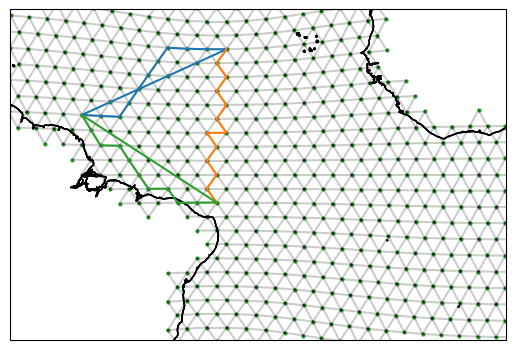

In [13]:
fig, ax = setup_plot_area(ds_IsD)
for section in reconstructed_sections:
    reconstructed_sections[section].plot(ax=ax, gridlines=False)

In the above we can see a funny straight line in the blue and green section. This is a bug that will be adressed in a future version. It arises from the repeating of the first vertex along the section at the end of the section. The edge paths remain unaffected though.

In [24]:
blue_sec = reconstructed_sections["Shortest Section (sum of edge lengths)"]

In [32]:
blue_sec.vertex_path

<xarray.DataArray 'vertex' (step_in_path_v: 12)> Size: 48B
array([2835, 2837, 3618, 3627, 3626, 3551, 3550, 3610, 3611, 3601, 3602, 2835],
      dtype=int32)
Coordinates:
    vlon          (step_in_path_v) float64 96B -51.3 -49.04 ... -33.8 -51.3
    vlat          (step_in_path_v) float64 96B 7.224 7.106 6.998 ... 15.17 7.224
    vertex        (step_in_path_v) int32 48B 2835 2837 3618 ... 3601 3602 2835
    step_in_path  (step_in_path_v) int64 96B 0 1 2 3 4 5 6 7 8 9 10 32
Dimensions without coordinates: step_in_path_v

In [36]:
blue_sec.edge_path

<xarray.DataArray 'edge' (step_in_path: 10)> Size: 40B
array([ 7752, 10079, 10113, 10097, 10108,  9853, 10062, 10049, 10065, 10006],
      dtype=int32)
Coordinates:
    elon          (step_in_path) float64 80B -50.17 -47.89 ... -37.39 -35.0
    elat          (step_in_path) float64 80B 7.166 7.053 7.848 ... 15.2 15.17
    edge          (step_in_path) int32 40B 7752 10079 10113 ... 10065 10006
    step_in_path  (step_in_path) int64 80B 1 2 3 4 5 6 7 8 9 10